In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
import tensorflow as tf

# Fetch historical stock data using Yahoo Finance
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['Tomorrow'] = stock_data['Close'].shift(-1)
    return stock_data.dropna()  # Remove rows with NaN in 'Tomorrow' column

# Preprocess the data and prepare it for the RL environment
def preprocess_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Define the RL environment for stock trading
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.current_step = 0
        self.max_steps = len(data)
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(len(data[0]),), dtype=np.float32)
    
    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.actions_memory = []
        return self.data[self.current_step]
    
    def step(self, action):
        if self.current_step >= self.max_steps - 1:
            # If we have reached the end of the data, return zeros and mark the episode as done
            return np.zeros_like(self.data[0]), 0, True, {}

        # Get the current price and the action taken
        current_price = self.data[self.current_step, 0]  # Assuming price is the first column
        action_type = action  # Assuming action is represented as integers (0 for Buy, 1 for Sell, 2 for Hold)

        # Calculate the reward based on the action taken
        if action_type == 0:  # Buy
            reward = -current_price  # Buying at the current price
            self.balance -= current_price
        elif action_type == 1:  # Sell
            reward = current_price  # Selling at the current price
            self.balance += current_price
        else:  # Hold
            reward = 0  # No immediate reward for holding

        # Move to the next time step
        self.current_step += 1

        # Check if the episode is done (whether we have reached the end of the data)
        done = self.current_step >= self.max_steps - 1

        # Get the next observation (state)
        next_observation = self.data[self.current_step]

        # Additional information (optional)
        info = {}  # Additional information, if needed

        return next_observation, reward, done, info

# Define and train the DRL model
def train_rl_model(data):
    env = DummyVecEnv([lambda: StockTradingEnv(data)])
    model = A2C('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=10000)  # Adjust as needed
    return model

# Fetch and preprocess data
stock_data = fetch_stock_data('^NSEI', '2020-01-01', '2024-02-17')
processed_data, scaler = preprocess_data(stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow']].values)

# Train the RL model
rl_model = train_rl_model(processed_data)

# Make predictions using the trained model
def make_predictions(model, data):
    env = DummyVecEnv([lambda: StockTradingEnv(data)])
    obs = env.reset()
    predictions = []
    for _ in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, _, _ = env.step(action)
        predictions.append(action)
    return predictions

predictions = make_predictions(rl_model, processed_data)

model_nn = Sequential()
model_nn.add(Dense(128, activation='relu', input_shape=(len(processed_data[0]) - 1,)))  # Increase number of neurons in the first hidden layer
model_nn.add(Dense(64, activation='relu'))  # Add an additional hidden layer
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1, activation='linear'))  # Output layer with linear activation for predicting continuous value

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_nn.compile(optimizer= optimizer, loss='mean_squared_error')

# Train the neural network model
X_train_nn = processed_data[:-100, :-1]  # Exclude 'Tomorrow' column from features
y_train_nn = processed_data[:-100, -1]   # 'Tomorrow' column as target
X_test_nn = processed_data[-100:, :-1]
y_test_nn = processed_data[-100:, -1]

model_nn.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, validation_data=(X_test_nn, y_test_nn))

# Make predictions using the neural network model
pred_nn = model_nn.predict(X_test_nn)

print("Predictions for tomorrow's closing price:")
print(pred_nn)


/var/folders/lh/_jlbww852_718k4bwr365mj40000gn/T/ipykernel_11514/3685932094.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 3561     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.513   |
|    explained_variance | 0.877    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.088    |
|    value_loss         | 0.222    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 3847     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.0354  |
|    explained_variance | 0.0384   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.0263   |
|    value_loss      

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2917 - val_loss: 0.0689
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0067
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0024
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predictions for tomorrow's closing price:
[[1.2243378 ]
 [1.1732937 ]
 [1.151353  ]
 [1.1272297 ]
 [1.1378915 ]
 [1.1321001 ]
 [1.11

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


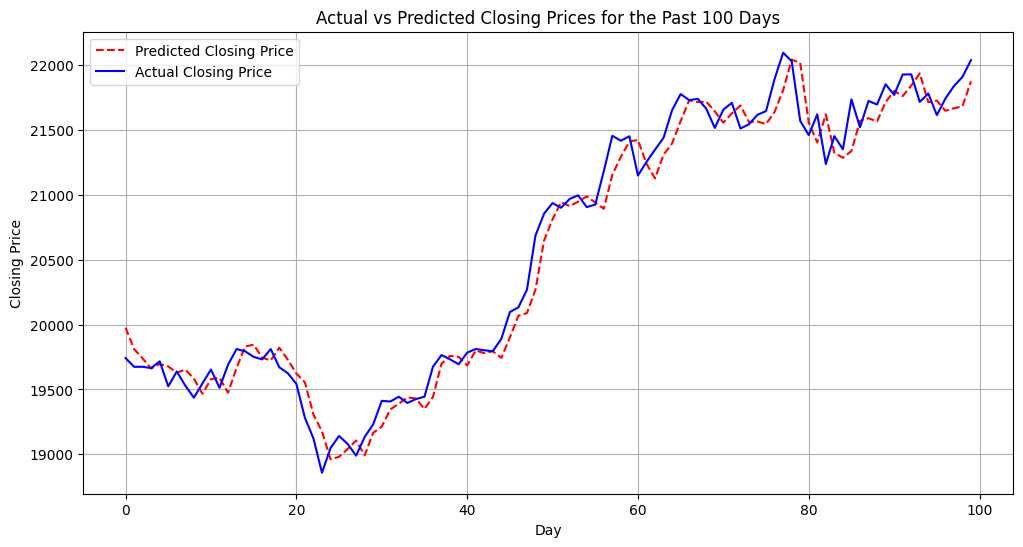

In [4]:
import matplotlib.pyplot as plt

# Predict closing prices for the past 100 days
predicted_prices = model_nn.predict(X_test_nn)

# Inverse transform the predicted prices to get the actual values
predicted_prices = scaler.inverse_transform(np.hstack((X_test_nn, predicted_prices)))

# Extract actual closing prices for the past 100 days
actual_prices = scaler.inverse_transform(np.hstack((X_test_nn, y_test_nn.reshape(-1, 1))))

# Plot the actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(predicted_prices[:, -1], label='Predicted Closing Price', color='red', linestyle='--')
plt.plot(actual_prices[:, -1], label='Actual Closing Price', color='blue', linestyle='-')
plt.title('Actual vs Predicted Closing Prices for the Past 100 Days')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


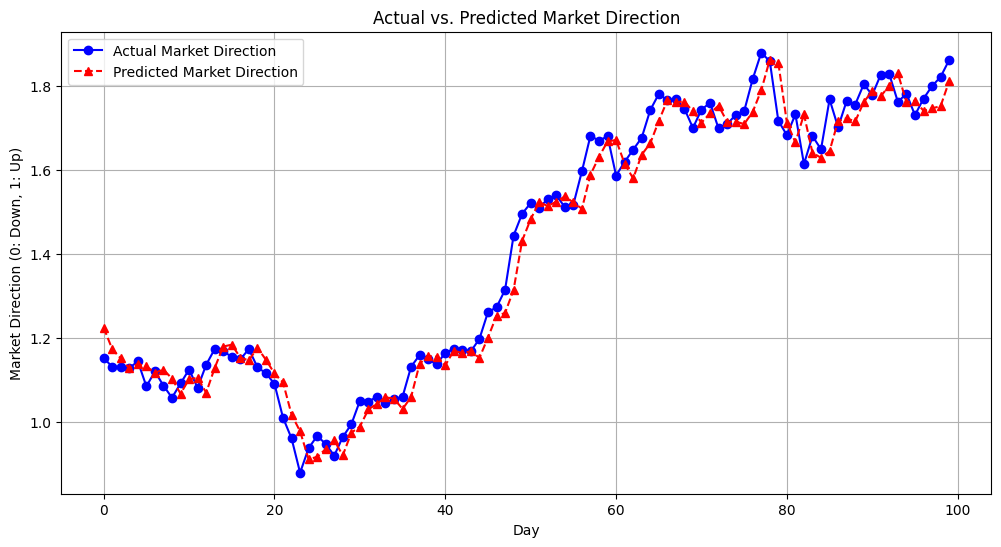

In [5]:
import matplotlib.pyplot as plt

# Create an array of days for the x-axis
days = range(len(y_test_nn))

# Plot the actual labels (0 for down, 1 for up)
plt.figure(figsize=(12, 6))
plt.plot(days, y_test_nn, label='Actual Market Direction', color='blue', marker='o', linestyle='-')

# Plot the predicted labels
plt.plot(days, pred_nn, label='Predicted Market Direction', color='red', marker='^', linestyle='--')

plt.title('Actual vs. Predicted Market Direction')
plt.xlabel('Day')
plt.ylabel('Market Direction (0: Down, 1: Up)')
plt.legend()
plt.grid(True)
plt.show()


      Actual  Predicted
0   1.152199   1.224338
1   1.131198   1.173294
2   1.131290   1.151353
3   1.128252   1.127230
4   1.144212   1.137892
..       ...        ...
95  1.730040   1.764522
96  1.769267   1.740373
97  1.799120   1.746190
98  1.820923   1.751418
99  1.860999   1.810460

[100 rows x 2 columns]


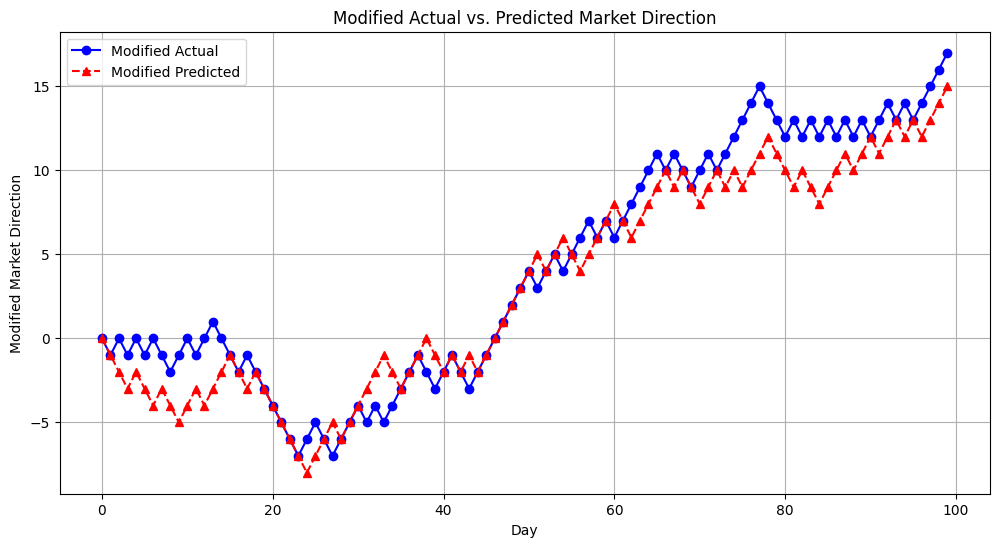

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with actual and predicted values
df = pd.DataFrame({'Actual': y_test_nn, 'Predicted': pred_nn.flatten()})

# Display the DataFrame
print(df)

# Create arrays to store modified values for actual and predicted market directions
modified_actual = []
modified_predicted = []

# Initialize variables to track the previous day's value
prev_actual = None
prev_predicted = None

# Iterate through actual and predicted market directions
for actual, predicted in zip(y_test_nn, pred_nn):
    # Calculate the modified value for actual market direction
    if prev_actual is None:
        modified_actual.append(0)
    else:
        modified_actual.append(modified_actual[-1] + (1 if actual > prev_actual else -1))
    prev_actual = actual
    
    # Calculate the modified value for predicted market direction
    if prev_predicted is None:
        modified_predicted.append(0)
    else:
        modified_predicted.append(modified_predicted[-1] + (1 if predicted > prev_predicted else -1))
    prev_predicted = predicted

# Create an array of days for the x-axis
days = range(len(y_test_nn))

# Plot the modified values for actual and predicted market directions
plt.figure(figsize=(12, 6))
plt.plot(days, modified_actual, label='Modified Actual', color='blue', marker='o', linestyle='-')
plt.plot(days, modified_predicted, label='Modified Predicted', color='red', marker='^', linestyle='--')

plt.title('Modified Actual vs. Predicted Market Direction')
plt.xlabel('Day')
plt.ylabel('Modified Market Direction')
plt.legend()
plt.grid(True)
plt.show()
